### Figure 2. Antagonism of striatal NMDARs robustly diminishes striatal bulk calcium activity.  

Install and import all packages

In [18]:
import pickle
import invian
import numpy as np
import os
import zipfile
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
from sklearn.linear_model import LinearRegression
from osfclient import OSF
from scipy.signal import find_peaks, periodogram, spectrogram, filtfilt, butter, find_peaks_cwt, correlate, peak_prominences, welch

plt.rcParams.update({
    'font.size': 32, 
    'figure.autolayout': True, 
    'lines.linewidth': 2, 
    'axes.spines.top': False, 
    'axes.spines.right': False
    })

warnings.filterwarnings("ignore")

Define Functions

In [2]:
def find_adjust_peaks(signal, widths, min_snr, sr, threshold=0, prominence=0):
    peaks = find_peaks_cwt(signal, widths, min_snr=min_snr)
    
    c_threshold = np.std(signal) * threshold
    
    adjusted_peaks = []
    for peak in peaks:
        start_index = max(0, peak - sr)
        end_index = min(len(signal) - 1, peak + sr)
        local_max_index = np.argmax(signal[start_index:end_index + 1]) + start_index
        
        
        if signal[local_max_index] > c_threshold:
            adjusted_peaks.append(local_max_index)
    
    peak_proms = peak_prominences(signal, adjusted_peaks)[0]
    
    f_peaks = [adjusted_peaks[i] for i in range(len(peak_proms)) if (peak_proms[i] > prominence)]
    
    f_peaks = np.array(list(set(f_peaks)))  # Remove duplicates
    
    return f_peaks

#Temp functions
def butter_filter(signal, filt_type, freqs, sr, order=3):
    b,a = butter(order, freqs, btype=filt_type, fs=sr)
    y=filtfilt(b, a, signal, padtype="even")
    
    return y


Fetching data from OSF and extracting it

In [3]:
# Create output directory
output_dir = "osf_downloads"
os.makedirs(output_dir, exist_ok=True)

# Connect to OSF
osf = OSF()
project = osf.project('stk2r')
storage = project.storage('osfstorage')

# Set up folder name with data
target_filename = 'Figure_2_data.zip'

# Download zip file with data
for file in storage.files:
    if file.name == target_filename:
        output_path = os.path.join(output_dir, file.name)
        with open(output_path, 'wb') as f:
            file.write_to(f)
        print(f"Downloaded: {file.name} to {output_path}")
        break
else:
    print(f"File '{target_filename}' not found in OSF storage.")

#Set up 
zip_path = 'osf_downloads/Figure_2_data.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"Extracted all files to {output_dir}")

100%|██████████| 161M/161M [00:58<00:00, 2.75Mbytes/s] 


Downloaded: Figure_2_data.zip to osf_downloads\Figure_2_data.zip
Extracted all files to osf_downloads


Formatting the data for analysis

In [4]:
fileloc = os.path.join(os.getcwd(), "osf_downloads", "Figure_2_data")

raw_data_mk801 = {
    "saline": {
        "C115a": pd.read_csv(fileloc + r"\c115a_icv_saline_050124.csv"),
        "C115c": pd.read_csv(fileloc + r"\c115c_icv_saline_061724.csv"),
        "FC1M1": pd.read_csv(fileloc + r"\fc1m1_icv_saline_070324.csv"),
        "FC1M2": pd.read_csv(fileloc + r"\fc1m2_icv_saline_070924.csv"),
        "FC2F1": pd.read_csv(fileloc + r"\fc2f1_icv_saline_081324.csv"),
        "GAC1M1": pd.read_csv(fileloc + r"\GAC1M1_icv_saline_081324.csv"),
        "GAC1M2": pd.read_csv(fileloc + r"\GAC1M2_icv_saline_081424.csv"),
        "FC3M2": pd.read_csv(fileloc + r"\fc3m2_icv_saline_082124.csv"),
        "FC3M3": pd.read_csv(fileloc + r"\fc3m3_icv_saline_082924.csv"),
        "FC3M5": pd.read_csv(fileloc + r"\fc3m5_icv_saline_091724.csv")
        },
    "0.1mgml": {
        "FC3M5": pd.read_csv(fileloc + r"\fc3m5_icv_mk801_0.1mgml_081924.csv"),
        "FC1M3": pd.read_csv(fileloc + r"\fc1m3_icv_mk801_0.1mgml_081924.csv"),
        "FC1M2": pd.read_csv(fileloc + r"\fc1m2_icv_mk801_0.1mgml_081924.csv"),
        "FC1M1": pd.read_csv(fileloc + r"\fc1m1_icv_mk801_0.1mgml_090224.csv"),
        "FC3M2": pd.read_csv(fileloc + r"\fc3m2_icv_mk801_0.1mgml_090224.csv"),
        "FC3M3": pd.read_csv(fileloc + r"\fc3m3_icv_mk801_0.1mgml_091724.csv")
        },
    "1mgml": {
        "C115c": pd.read_csv(fileloc + r"\c115c_icv_mk801_1mgml_070224.csv"),
        "C115d": pd.read_csv(fileloc + r"\c115d_icv_MK801_1mgkg_072624.csv"),
        "C115a": pd.read_csv(fileloc + r"\c115a_icv_mk801_1mgkg_072924.csv"),
        "FC1M1": pd.read_csv(fileloc + r"\fc1m1_icv_mk801_1mgkg_0730242.csv"),
        "FC1M3": pd.read_csv(fileloc + r"\fc1m3_icv_mk801_1mgkg_073024.csv"),
        "FC1M2": pd.read_csv(fileloc + r"\fc1m2_icv_mk801_1mgml_090324.csv")
        },
    "2mgml": {
        "C115a": pd.read_csv(fileloc + r"\c115a_icv_mk801_2mgml_061824.csv"),
        "C115d": pd.read_csv(fileloc + r"\c115d_icv_mk801_2mgml_070224.csv"),
        "FC1M1": pd.read_csv(fileloc + r"\fc1m1_icv_mk801_2mgml_071724.csv"),
        "FC1M2": pd.read_csv(fileloc + r"\fc1m2_icv_mk801_2mgml_072424.csv"),
        "GAC1M1": pd.read_csv(fileloc + r"\GAC1M1_icv_mk801_2mgml_082024.csv"),
        "FC1M3": pd.read_csv(fileloc + r"\fc1m3_icv_mk801_2mgml_082624.csv")
        },
    "4mgml": {
        "C115c": pd.read_csv(fileloc + r"\c115c_icv_mk801_042324.csv"),
        "FC1M1": pd.read_csv(fileloc + r"\fc1m1_icv_mk801_4mgml_072524.csv"),
        "C115a": pd.read_csv(fileloc + r"\c115a_icv_mk801_4mgml_080524.csv"),
        "FC1M2": pd.read_csv(fileloc + r"\FC1M2_icv_mk801_4mgml_081224.csv"),
        "FC1M3": pd.read_csv(fileloc + r"\FC1M3_icv_mk801_4mgml_0813242.csv"),
        "FC3M2": pd.read_csv(fileloc + r"\fc3m2_icv_mk801_4mgml_0918242.csv")
        }
    }

metadata = pd.read_csv(fileloc + r"\all_metadata_082225.csv")

print("All files were successfully formatted")

All files were successfully formatted


Visualize the raw data

Text(0, 0.5, 'Isos Int.(AU)')

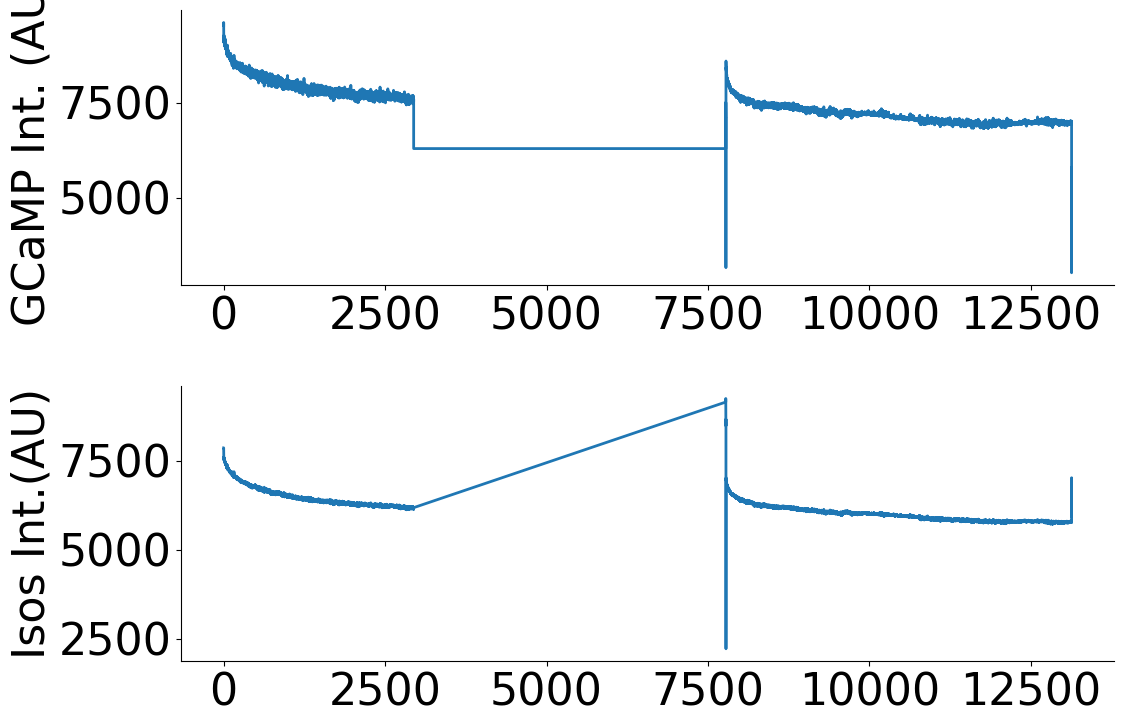

In [5]:
"""
There are:
Four treatments: "saline", "0.1mgml", "1mgml", "2mgml", "4mgml"
Twelve mice: "C115a", "C115c", "C115d", "FC1M1", "FC1M2", "FC1M3", "FC3M2", "FC2F1", "GAC1M1", "GAC1M2", "FC3M3", "FC3M5".
Not every mouse is in all treatment groups. For mapping please see "Formatting data for analysis" cell
"""

group = "4mgml"
mouse = "FC3M2"

t_ts = (raw_data_mk801[group][mouse]["Time"] - raw_data_mk801[group][mouse]["Time"].iloc[0])

fig, ax = plt.subplots(2,1, figsize=(12,8))
ax[0].plot(t_ts, raw_data_mk801[group][mouse]["Fluorescence"])
ax[0].set_ylabel("GCaMP Int. (AU)")
ax[1].plot(t_ts, raw_data_mk801[group][mouse]["Isosbestic"])
ax[1].set_ylabel("Isos Int.(AU)")

Pre-process photometry data

In [6]:
"""
The photometry data is processed in the following manner.
A linear regression is used to fit the isosbestic data to the gcamp signal (noise_hat). The gcamp signal is processed as follows.
    norm_gcamp = (raw_gcamp - noise_hat) / noise_hat
This is analogous to a df/f given that the noise_hat represents the floor of the gcamp signal (f0). Importantly, the regression is fit on the
baseline data, and this fitted regression is used for the calculation of the df/f of both the baseline and the post-MK801 data.
This signal is then filtered using a bandpass digital filter that allows frequencies >0.005, <6 HZ.
"""

p_data = {}
ts = {}
for condition in raw_data_mk801:
    p_data[condition] = {}
    ts[condition] = {}
    
    c_condition = raw_data_mk801[condition]
    
    for mouse in c_condition:
        p_data[condition][mouse] = {}
        ts[condition][mouse] = {}
        
        c_data = c_condition[mouse]
        c_data["norm_timestamp"] = c_data["Time"] - c_data["Time"].iloc[0]
        
        c_ts = c_data["norm_timestamp"].iloc[150:].to_numpy()
        c_isos = c_data["Isosbestic"].iloc[150:].to_numpy()
        c_gcamp = c_data["Fluorescence"].iloc[150:].to_numpy()
        
        c_events = metadata[np.logical_and(metadata["Mouse"] == mouse, metadata["Treatment"] == condition)]
        c_baseline_end = np.searchsorted(c_ts, c_events["Baseline_end"].values)[0]
        c_post_start = np.searchsorted(c_ts, c_events["Post_start"].values+600)[0]
        c_post_end = np.searchsorted(c_ts, c_events["Post_start"].values+4200)[0]
        
       
        #We slice and normalize baseline
        c_baseline_ts = c_ts[:c_baseline_end]
        c_baseline_isos = c_isos[:c_baseline_end]
        c_baseline_gcamp = c_gcamp[:c_baseline_end]
        
        regr = LinearRegression()
        regr.fit(c_baseline_isos.reshape(-1,1), c_baseline_gcamp.reshape(-1,1))
        c_baseline_hat = regr.predict(c_baseline_isos.reshape(-1,1))
        
        c_norm_baseline = (c_baseline_gcamp - c_baseline_hat[:,0])/c_baseline_hat[:,0]
        c_norm_baseline_2 = butter_filter(c_norm_baseline, "bandpass", (0.005,10), 40)
        #c_norm_baseline_2 = bp_filter(c_norm_baseline, 0.005, 10, 40)
        c_norm_baseline_3 = c_norm_baseline_2
        #c_norm_baseline_3 = (c_norm_baseline_2 - c_norm_baseline_2.mean()) / c_norm_baseline_2.std()
        
        #
        c_post_ts = c_ts[c_post_start:c_post_end]
        c_post_isos = c_isos[c_post_start:c_post_end]
        c_post_gcamp = c_gcamp[c_post_start:c_post_end]
        
        c_post_hat = regr.predict(c_post_isos.reshape(-1,1))
        
        c_norm_post = (c_post_gcamp - c_post_hat[:,0]) / c_post_hat[:,0]
        c_norm_post_2 = butter_filter(c_norm_post, "bandpass", (0.005,10), 40)
        #c_norm_post_2 = bp_filter(c_norm_post, 0.005, 10, 40)
        c_norm_post_3 = c_norm_post_2
        #c_norm_post_3 = (c_norm_post_2 - c_norm_post_2.mean()) / c_norm_post_2.std()
        
        p_data[condition][mouse]["Baseline"] = c_norm_baseline_3
        p_data[condition][mouse]["Post"] = c_norm_post_3
        
        ts[condition][mouse]["Baseline"] = c_baseline_ts
        ts[condition][mouse]["Post"] = c_post_ts

print("All photometry data was successfully pre-processed")

All photometry data was successfully pre-processed


Visualizing processed photometry data

Text(0, 0.5, 'Post df/f')

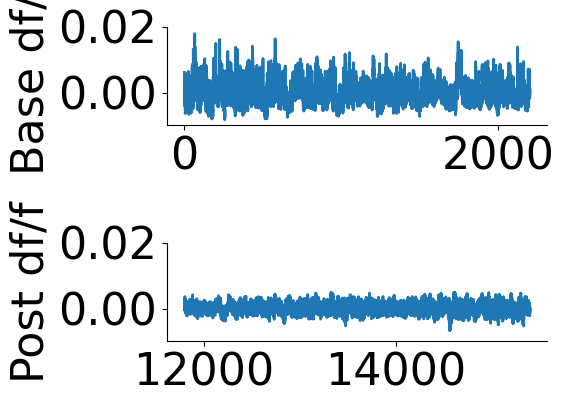

In [7]:
"""
There are:
Four treatments: "saline", "0.1mgml", "1mgml", "2mgml", "4mgml"
Twelve mice: "C115a", "C115c", "C115d", "FC1M1", "FC1M2", "FC1M3", "FC3M2", "FC2F1", "GAC1M1", "GAC1M2", "FC3M3", "FC3M5".
Not every mouse is in all treatment groups. For mapping please see "Formatting data for analysis" cell
"""

group = "2mgml"
mouse = "FC1M3"

fig, ax = plt.subplots(2,1)
ax[0].plot(ts[group][mouse]["Baseline"], p_data[group][mouse]["Baseline"])
ax[0].set_ylabel("Base df/f")
ax[1].plot(ts[group][mouse]["Post"], p_data[group][mouse]["Post"])
ax[0].set_ylim(-0.01,0.02)
ax[1].set_ylim(-0.01,0.02)
ax[1].set_ylabel("Post df/f")
            

Finding or importing the peaks

In [8]:
"""
Here the peaks in activity (transients) are found using a wavelet transformation method (see) https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks_cwt.html.
and the "find_adjust_peaks" function. Running the algorithm will be VERY SLOW. Thus by default, this cell will import the peaks that were previously saved in a pickle file.
Running the algorithm should lead to the exact same peaks. To run the algorithm, set find_peaks_from_scratch to True.
"""

find_peaks_from_scratch = False
if find_peaks_from_scratch:
    peaks_mk801 = {}
    peak_ts = {}
    for condition in p_data:
        peaks_mk801[condition] = {}
        peak_ts[condition] = {}
        c_condition = p_data[condition]
        
        for mouse in c_condition:
            print(condition, mouse)
            peaks_mk801[condition][mouse] = {}
            peak_ts[condition][mouse] = {}
            c_baseline_ts = ts[condition][mouse]["Baseline"]
            c_baseline_vals = p_data[condition][mouse]["Baseline"]
            
            c_post_ts = ts[condition][mouse]["Post"]
            c_post_vals = p_data[condition][mouse]["Post"]

            c_baseline_peaks_mk801 = find_adjust_peaks(c_baseline_vals, widths, min_snr, 40, threshold=thresh)
            c_post_peaks_mk801 = find_adjust_peaks(c_post_vals, widths, min_snr, 40, prominence=prominence)
            
            peaks_mk801[condition][mouse]["Baseline"] = c_baseline_peaks_mk801
            peaks_mk801[condition][mouse]["Post"] = c_post_peaks_mk801
            
            
            c_baseline_ts = ts[condition][mouse]["Baseline"]
            peak_ts[condition][mouse]["Baseline"] = c_baseline_ts[c_baseline_peaks_mk801]
            
            c_post_ts = ts[condition][mouse]["Post"]
            if len(c_post_peaks_mk801) > 0:
                peak_ts[condition][mouse]["Post"] = c_post_ts[c_post_peaks_mk801]
            else:
                peak_ts[condition][mouse]["Post"] = []

else:
    with open(fileloc + r'\icv_photometry_peaks_mk801_081525.p', 'rb') as fp:
        peaks_mk801 = pickle.load(fp)


Visualize the peaks

Text(0.5, 1.0, '2mgml, FC1M2 Post')

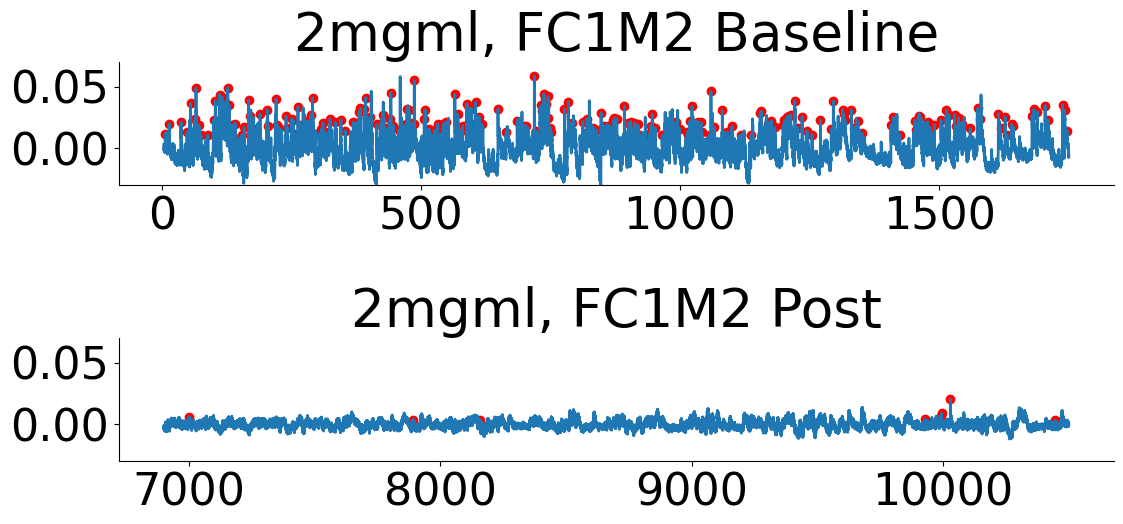

In [ ]:
"""
There are:
Four treatments: "saline", "0.1mgml", "1mgml", "2mgml", "4mgml"
Twelve mice: "C115a", "C115c", "C115d", "FC1M1", "FC1M2", "FC1M3", "FC3M2", "FC2F1", "GAC1M1", "GAC1M2", "FC3M3", "FC3M5".
Not every mouse is in all treatment groups. For mapping please see "Formatting data for analysis" cell
"""
group = "2mgml"
mouse = "FC1M2"

fig, ax = plt.subplots(2,1, figsize=(12,6))
ax[0].plot(ts[group][mouse]["Baseline"], p_data[group][mouse]["Baseline"])
ax[0].scatter(ts[group][mouse]["Baseline"][peaks_mk801[group][mouse]["Baseline"]], p_data[group][mouse]["Baseline"][peaks_mk801[group][mouse]["Baseline"]], c="red")
ax[0].set_ylim(-0.03,0.07)
ax[0].set_title(f"{group}, {mouse} Baseline")
ax[1].plot(ts[group][mouse]["Post"], p_data[group][mouse]["Post"])
ax[1].scatter(ts[group][mouse]["Post"][peaks_mk801[group][mouse]["Post"]], p_data[group][mouse]["Post"][peaks_mk801[group][mouse]["Post"]], c="red")
ax[1].set_ylim(-0.03,0.07)
ax[1].set_title(f"{group}, {mouse} Post")

Calculating and plotting the transient rate

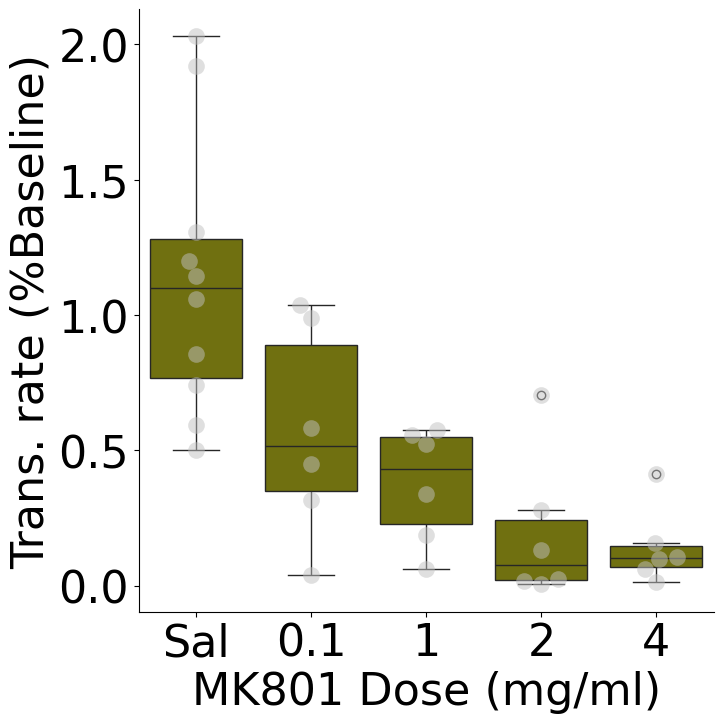

In [19]:
peak_rate_df = []
for condition in peaks_mk801:
    c_condition_peaks = peaks_mk801[condition]
    
    for mouse in c_condition_peaks:
        c_peaks_baseline = c_condition_peaks[mouse]["Baseline"].size
        c_time_baseline = ts[condition][mouse]["Baseline"][-1] - ts[condition][mouse]["Baseline"][0]
        c_peak_rate_baseline = c_peaks_baseline/(c_time_baseline/60)
        
        c_peaks_post = c_condition_peaks[mouse]["Post"].size
        c_time_post = ts[condition][mouse]["Post"][-1] - ts[condition][mouse]["Post"][0]
        c_peak_rate_post = c_peaks_post/(c_time_post/60)
        
        
        c_df = pd.DataFrame({"Mouse": mouse, "Baseline": [c_peak_rate_baseline],
                             "Post": [c_peak_rate_post], "Treatment": condition})
        peak_rate_df.append(c_df)

peak_rate_df = pd.concat(peak_rate_df).reset_index(drop=True)
peak_rate_df["Change"] = peak_rate_df["Post"] / peak_rate_df["Baseline"]

doses = ["saline", "0.1mgml", "1mgml", "2mgml", '4mgml']
peak_rate_df["Treatment"] = pd.Categorical(peak_rate_df["Treatment"], ordered=True, categories=doses)

fig, ax = plt.subplots(figsize=(8,8))
#sns.lineplot(x="Treatment", y="Change", data=peak_rate_df, marker="o", linewidth=5, markersize=16, errorbar="se", err_style="bars", c="olive")
sns.boxplot(x="Treatment", y="Change", data=peak_rate_df, palette=["olive"])
sns.swarmplot(x="Treatment", y="Change", data=peak_rate_df, s=12, c="silver",alpha=0.5, dodge=True)
ax.set_xlabel("MK801 Dose (mg/ml)")
ax.set_ylabel("Trans. rate (%Baseline)")
ax.set_xticklabels(["Sal", "0.1", "1", "2", "4"])
sns.despine()

Calculating signal power